In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
np.random.seed(1337)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# Importing Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import pathlib
import cv2
from tensorflow.keras import layers
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
print(tf.__version__)

2.4.1


# Preparing dataset

Link to the [Dataset being used](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri)<br>
Reference Tutorial for general code: [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)

In [4]:
#path_data = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'
path_test = '../input/brain-tumor-classification-mri/Testing'
path_data = '../input/brain-tumor-classification-mri/Training'


path_test = pathlib.Path(path_test)
path_data = pathlib.Path(path_data)
print(path_data)

image_count = len(list(path_data.glob('*/*.jpg')))
print(image_count)
test_image_count = len(list(path_test.glob('*/*.jpg')))
print(test_image_count)

../input/brain-tumor-classification-mri/Training
2870
394


#### Image of a brain with tumor

../input/brain-tumor-classification-mri/Training/glioma_tumor/gg (552).jpg


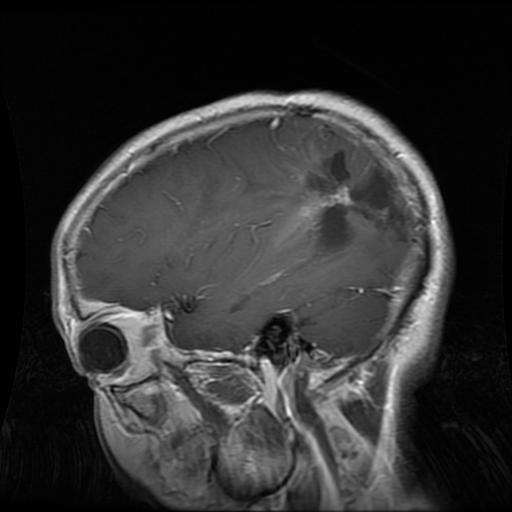

In [5]:
tumors = list(path_data.glob('glioma_tumor/*'))
print(tumors[1])
img1 = PIL.Image.open(str(tumors[0]))
img1

#### Image of a brain with no tumor

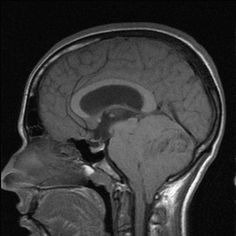

In [6]:
not_tumors = list(path_data.glob('no_tumor/*'))
img2 = PIL.Image.open(str(not_tumors[0]))
img2

In [7]:
img_opencv = cv2.imread(str(not_tumors[0]))
print(img_opencv.shape)
img_opencv1 = cv2.imread(str(tumors[0]))
print(img_opencv1.shape)

(236, 236, 3)
(512, 512, 3)


### Creating Testing Validation and Testing Sets

In [8]:
batch = 32
img_height = 250
img_width = 250

In [9]:
train = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'training',
seed = 42,
image_size  =(img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.


In [10]:
val = tf.keras.preprocessing.image_dataset_from_directory(
path_data,
validation_split = 0.2,
subset = 'validation',
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [11]:
test = tf.keras.preprocessing.image_dataset_from_directory(
path_test,
seed = 42,
image_size = (img_height,img_width),
batch_size = batch)

Found 394 files belonging to 4 classes.


In [12]:
print(train.class_names)
print(val.class_names)
print(test.class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


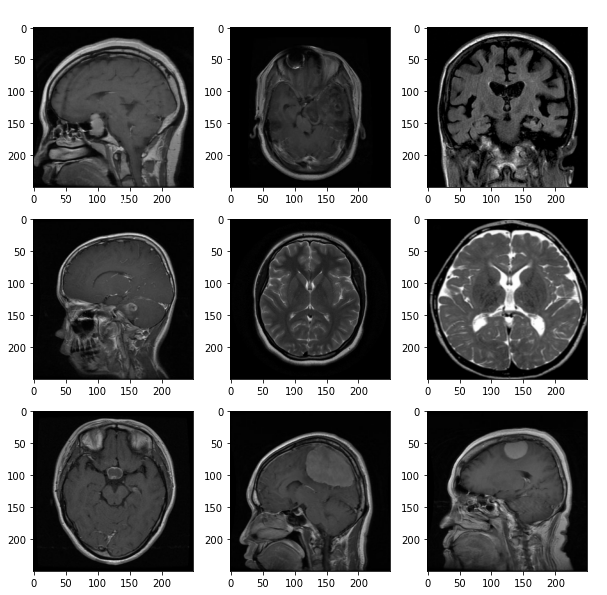

In [13]:
classes = train.class_names
plt.figure(figsize = (10,10))
for img,label in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]],
                  fontdict = {'fontsize': '19',
                              'color': 'white'}
                 )
        

In [14]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)
val = val.prefetch(buffer_size=AUTOTUNE)
test = test.prefetch(buffer_size=AUTOTUNE)

In [16]:
help(test.as_numpy_iterator())

Help on _NumpyIterator in module tensorflow.python.data.ops.dataset_ops object:

class _NumpyIterator(builtins.object)
 |  _NumpyIterator(dataset)
 |  
 |  Iterator over a dataset with elements converted to numpy.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dataset)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  __next__(self)
 |  
 |  next(self)



# Helper Functions
<a id='helper'></a>
<a id ='compare'></a>

In [17]:
def prediction_label_comparison(model,test):
    #Retrieve a batch of images from the test set
    image_batch, label_batch = test.as_numpy_iterator().next()
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        predict.append(pred)
    predict = np.array(predict)

    #print('Predictions:\n',predictions)#.numpy())
    print('Labels:\n', label_batch)
    print('Predictions:\n',predict)
    '''
    print(predictions.shape)
    print(label_batch.shape)
    print(predict.shape)
    '''

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(classes[predict[i]],fontdict = {'fontsize': '14',
                                  'color': 'white'})
      plt.axis("off")
    return label_batch , predict

In [18]:
def test_tumor(list_test_path,model):
    # sunflower_url = 'https://'
    # sunflower_path = tf.keras.utils.get_file('name of file', origin=sunflower_url)
    for path_name in list_test_path:
        test_img_path = path_name


        test_image = tf.keras.preprocessing.image.load_img(
            test_img_path, target_size=(img_height, img_width)
        )
        test_array = tf.keras.preprocessing.image.img_to_array(test_image)
        test_array = tf.expand_dims(test_array, 0) # Create a batch

        predictions = model.predict(test_array)
        score = tf.nn.softmax(predictions[0])

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(classes[np.argmax(score)], 100 * np.max(score))
        )

In [19]:
def csv_builder(path_data,label_names):
    df = pd.DataFrame(columns = ['images','labels'])
    for name in label_names:
        BASE_DIR = str(path_data)+'/'
        #train_folder_glioma = BASE_DIR+'glioma_tumor/'
        train_folder_name = BASE_DIR+name+'/'

        #train_annotation = BASE_DIR+'annotated_train_data/'

        files_in_train = sorted(os.listdir(train_folder_name))
        #files_in_annotated = sorted(os.listdir(train_annotation))

        image_names =[i for i in files_in_train]

        
        for x in image_names:
            df = df.append({'images':train_folder_name+str(x),'labels':name},ignore_index=True)
            #df = df.append({'images':str(x),'labels':name},ignore_index=True)

        #df['images']=[train_folder_glioma+str(x) for x in image_names]
        #df['labels']=[train_annotation+str(x) for x in images]
        #pd.to_csv('files_path.csv', header=None)
    return df

In [20]:
def model_inputs(model2,train,val,test):
    num_classes = 4
    epochs = 15
    model2.fit(
        train,
        validation_data=val,
        epochs=epochs,
        #callbacks = callback,
        shuffle=False,
        verbose = 0
    )
    results = model2.evaluate(test)
    return results[0],results[1] , model

In [21]:
def cross_validation(n_splits,final_csv,test_csv,img_width,img_height,model):
    final_loss = 0
    final_acc = 0

    '''
    Seperating a dataframe for testing data
    '''
    ##
    final_csv = final_csv.sample(frac=1)
    ##
    Y = final_csv[['labels']]
    n = len(Y)
    kf = KFold(n_splits = 5)
    #skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
    idg = ImageDataGenerator(#width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.3,
#                          fill_mode='nearest',
#                          horizontal_flip = True,
                         rescale=1./255)
    
    
    
    
    print('Performing cross validation...')
    test = idg.flow_from_dataframe(test_csv,
                                       x_col = "images",
                                       y_col = "labels",
                                       class_mode = "sparse",
                                       shuffle = True,
                                      target_size = (img_width,img_height),
                                      verbose = 0)#,subset='validation')
#     test = tf.keras.preprocessing.image_dataset_from_directory(path_test,
#                                                                    seed = 42,
#                                                                    image_size = (img_height,img_width),
#                                                                    batch_size = 32)

    for train_index, val_index in kf.split(np.zeros(n),Y):
        training_data = final_csv.iloc[train_index]
        validation_data = final_csv.iloc[val_index]
        train = idg.flow_from_dataframe(training_data,
                                        x_col = "images",
                                        y_col = "labels",
                                        class_mode = "sparse",
                                        shuffle = True,
                                        subset='training',
                                       target_size = (img_width,img_height),
                                       verbose = 0)
        val = idg.flow_from_dataframe(validation_data,
                                      x_col = "images",
                                      y_col = "labels",
                                      class_mode = "sparse",
                                      shuffle = True,
                                     target_size = (img_width,img_height),
                                     verbose = 0)	
        
#         if pretrained == 1:
#             # Create the base model from the pre-trained model MobileNet V2
#             image_size = (img_width,img_height)
#             IMG_SHAPE = image_size + (3,)
#             base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                            include_top=False,
#                                                            weights='imagenet')

#             base_model.trainable = False
#             ##
#             image_batch, label_batch = next(iter(train))
#             feature_batch = base_model(image_batch)
#             print(feature_batch.shape)
#             ##
#             global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#             feature_batch_average = global_average_layer(feature_batch)
#             ##
#             prediction_layer = tf.keras.layers.Dense(4)
#             prediction_batch = prediction_layer(feature_batch_average)
#             ##
#             preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#             ##
#             inputs = tf.keras.Input(shape=(250, 250, 3))
#             #x = data_augmentation(inputs)
#             x = preprocess_input(inputs)
#             x = base_model(x, training=False)
#             x = global_average_layer(x)
#             x = tf.keras.layers.Dropout(0.2)(x)
#             x = tf.keras.layers.Flatten()(x)
#             x = tf.keras.layers.Dense(1280,activation='relu')(x)
#             outputs = prediction_layer(x)
#             model = tf.keras.Model(inputs, outputs)
#             ##
#             base_learning_rate = 0.0001
#             model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                           metrics=['accuracy'])
#             ##
            
        
        '''
        Passing the preprocessed data for model training
        '''
        loss,acc,returned_model = model_inputs(model,train,val,test)
        final_loss += loss
        final_acc += acc
    return final_loss/n_splits , final_acc/n_splits , returned_model
   

In [22]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [23]:
data_augmentation = tf.keras.Sequential(
  [
    normalization_layer,
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
    #tf.keras.layers.experimental.preprocessing.RandomCrop(170,170)  
  ]
)

### Checking effects of the data augmentation

In [24]:
# IMG_SIZE = 180

# resize_and_rescale = tf.keras.Sequential([
#   tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#   tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# ])
# result = resize_and_rescale(img_opencv)
# _ = plt.imshow(result)

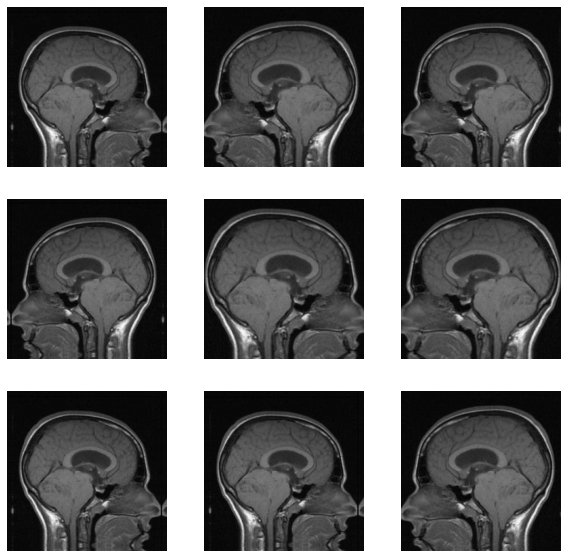

In [25]:
plt.figure(figsize=(10, 10))
img_array = tf.keras.preprocessing.image.img_to_array(img_opencv)
img_array = tf.expand_dims(img_array,0)
for i in range(9):
  augmented_image = data_augmentation(img_array)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Model Building

### References for model:<br>
Model 2: Obtained from a [Kaggle notebook](https://www.kaggle.com/chityeaung/brain-tumor-classification) by [chityeaung](https://www.kaggle.com/chityeaung)<br>
Model 1 and 3 taken from Tensorflow tutorials:<br>
[Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification)<br>
[Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

# First Model
<a id='first_model'></a>

In [26]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [28]:
history = model.fit(
    train,
    validation_data=val,
    epochs= 3,
    callbacks = callback,
    shuffle=False
)
eff_epochs = len(history.history['loss'])

Epoch 1/3
72/72 [==============================] - 28s 341ms/step - loss: 10.3744 - accuracy: 0.4617 - val_loss: 0.6426 - val_accuracy: 0.7666
Epoch 2/3
72/72 [==============================] - 8s 107ms/step - loss: 0.4763 - accuracy: 0.8264 - val_loss: 0.4073 - val_accuracy: 0.8484
Epoch 3/3
72/72 [==============================] - 8s 102ms/step - loss: 0.1500 - accuracy: 0.9579 - val_loss: 0.3406 - val_accuracy: 0.8902


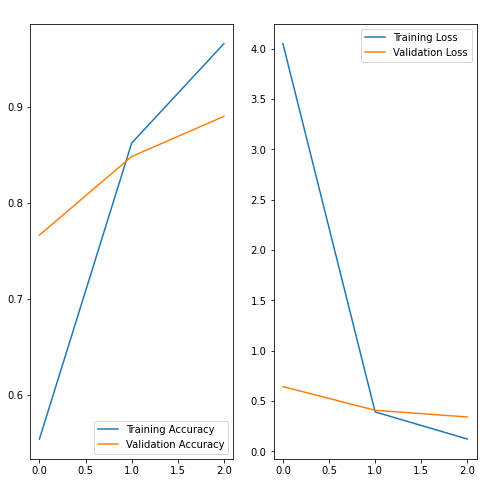

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               62980224  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 62,981,636
Trainable params: 62,981,636
Non-trainable params: 0
__________________________________________

In [31]:
results = model.evaluate(test)
print("test loss, test acc:", results)

13/13 [==============================] - 4s 82ms/step - loss: 2.0071 - accuracy: 0.6878
test loss, test acc: [2.007096767425537, 0.6878172755241394]


In [32]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 94.53 percent confidence.
This image most likely belongs to no_tumor with a 83.67 percent confidence.
This image most likely belongs to meningioma_tumor with a 98.83 percent confidence.
This image most likely belongs to no_tumor with a 98.67 percent confidence.
This image most likely belongs to no_tumor with a 75.19 percent confidence.


In [33]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 2 1 0 2 2 1 3 1 1 3 3 1 1 1 0 2 1 2 0 1 3 1 2 2 3 2 2 2 3 3 2 1 2 2 3 3
 2 1 2 2 2 1 0 2 0 3 1 1 1 2 2 2 3 3 2 2 2 1 3 2 2 2 2 2 3 2 2 2 3 1 1 2 0
 1 0 1 2 3 2 2 1 1 1 1 1 1 2 2 1 3 1 3 3 2 1 2 1 1 2 3 3 2 1 2 1 2 3 0 2 0
 2 1 3 1 3 2 1 2 2 2 2 2 2 1 3 1 2 1 1 2 1 2 2 1 3 3 1 2 2 2 1 2 1 2 2 2 0
 2 3 2 0 2 3 1 3 2 2 3 1 3 2 3 1 1 3 2 2 0 1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 3
 1 2 2 2 2 3 2 2 1 2 1 1 2 3 1 2 3 3 3 2 3 2 2 1 1 2 2 1 3 1 3 3 3 1 2 2 2
 2 2 3 0 1 1 1 2 2 1 3 2 2 2 1 2 3 3 1 1 2 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 2
 1 2 2 0 2 1 3 2 2 1 2 2 3 2 2 1 1 1 2 2 2 2 2 3 2 1 2 1 1 2 1 0 2 2 2 2 2
 3 1 1 3 1 1 2 3 2 2 2 2 1 1 1 3 3 2 2 2 2 2 3 1 2 3 2 2 2 1 2 3 2 1 1 2 2
 2 2 2 2 1 1 2 1 2 2 2 3 2 0 1 3 2 1 2 2 1 0 2 2 3 2 3 2 2 3 2 2 2 1 3 2 1
 1 1 2 2 2 3 2 3 3 3 2 3 1 3 1 2 2 1 2 2 2 2 1 2]
[2 0 1 0 2 2 1 3 1 1 3 0 2 1 1 0 0 1 0 0 3 3 1 2 2 1 2 2 1 3 3 2 1 2 1 3 3
 0 1 0 2 0 1 0 2 0 3 1 1 1 0 2 0 3 3 3 2 2 1 3 2 2 2 2 2 3 1 2 0 3 0 1 2 0
 1 0 1 1 3 0 1 1 1 1 1 1 3 2 2 1 3 1 3 3 2 1 0 1 3

In [34]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.17      0.29       100
meningioma_tumor       0.80      0.80      0.80       115
        no_tumor       0.54      0.97      0.69       105
 pituitary_tumor       0.83      0.81      0.82        74

        accuracy                           0.69       394
       macro avg       0.79      0.69      0.65       394
    weighted avg       0.79      0.69      0.65       394



# Second Model
<a id = 'second_model'></a>

Adding a data augmentation layer to add more images to the training data by simply modifying the existing images in ways such as flipping them or making similar random transformations to the training data.

In [35]:
num_classes = 4

model2 = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  conv_layer_32,
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

In [36]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
epochs = 50
history = model2.fit(
  train,
  validation_data=val,
  epochs=epochs,
  callbacks = callback,
  shuffle=False
)

Epoch 1/50
72/72 [==============================] - 9s 102ms/step - loss: 1.0607 - accuracy: 0.5400 - val_loss: 0.5382 - val_accuracy: 0.7892
Epoch 2/50
72/72 [==============================] - 8s 99ms/step - loss: 0.4593 - accuracy: 0.8311 - val_loss: 0.4202 - val_accuracy: 0.8449
Epoch 3/50
72/72 [==============================] - 8s 100ms/step - loss: 0.2883 - accuracy: 0.9010 - val_loss: 0.3725 - val_accuracy: 0.8641
Epoch 4/50
72/72 [==============================] - 8s 100ms/step - loss: 0.1756 - accuracy: 0.9471 - val_loss: 0.3158 - val_accuracy: 0.8920
Epoch 5/50
72/72 [==============================] - 8s 104ms/step - loss: 0.0947 - accuracy: 0.9684 - val_loss: 0.3273 - val_accuracy: 0.9077
Epoch 6/50
72/72 [==============================] - 8s 100ms/step - loss: 0.0885 - accuracy: 0.9722 - val_loss: 0.4021 - val_accuracy: 0.8885
Epoch 7/50
72/72 [==============================] - 7s 96ms/step - loss: 0.0579 - accuracy: 0.9843 - val_loss: 0.3746 - val_accuracy: 0.9007
Epoch 8/

In [38]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3936288   
_________________________________________________________________
dropout (Dropout)            (None, 32)               

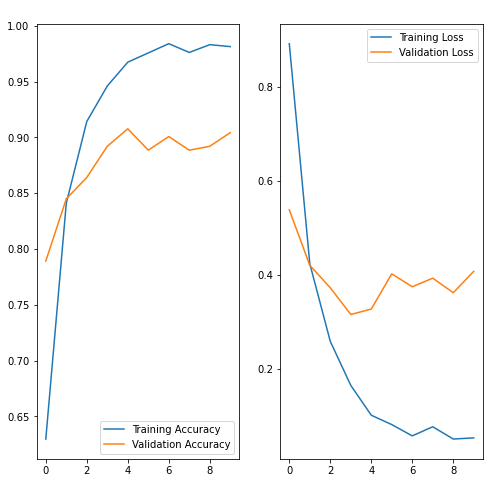

In [39]:
eff_epochs = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(eff_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.show()

In [40]:
results = model2.evaluate(test)
print("test loss, test acc:", results)

13/13 [==============================] - 1s 32ms/step - loss: 3.5719 - accuracy: 0.6878
test loss, test acc: [3.5719470977783203, 0.6878172755241394]


In [41]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model2)

This image most likely belongs to pituitary_tumor with a 47.51 percent confidence.
This image most likely belongs to no_tumor with a 45.57 percent confidence.
This image most likely belongs to meningioma_tumor with a 47.51 percent confidence.
This image most likely belongs to no_tumor with a 47.54 percent confidence.
This image most likely belongs to no_tumor with a 44.63 percent confidence.


In [42]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model2.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 3 3 3 1 1 1 2 2 1 1 1 3 2 3 3 1 3 0 2 2 1 1 1 2 2 3 2 2 2 2 2 3 2 2 1 2
 3 2 2 2 2 1 2 2 1 1 3 2 1 2 0 2 3 3 2 1 2 2 1 2 0 1 3 3 1 3 2 2 0 1 2 1 0
 2 1 1 1 2 2 1 3 2 1 3 2 2 1 2 3 2 2 0 3 2 2 2 1 1 2 1 2 2 1 2 3 2 2 2 2 3
 2 2 2 2 1 1 1 1 2 2 2 3 1 3 3 2 1 3 1 3 2 1 2 2 0 3 1 2 1 1 3 2 1 1 2 3 0
 1 2 1 1 1 2 2 2 0 1 2 3 1 1 2 1 0 2 2 2 1 3 2 2 2 3 1 2 2 2 2 1 2 2 2 2 3
 1 1 1 3 2 2 2 3 1 2 2 1 2 1 2 2 1 2 1 3 2 2 2 2 1 0 1 1 3 3 1 2 3 1 2 1 2
 0 2 1 1 2 2 1 2 3 3 2 1 2 0 0 3 2 3 1 1 3 1 1 2 2 2 1 1 1 2 2 3 3 2 3 2 2
 1 1 3 3 2 3 1 2 2 1 2 2 1 2 1 2 2 1 2 2 0 3 3 0 1 1 2 1 1 2 1 1 1 1 0 1 2
 1 2 2 1 2 1 3 3 2 2 2 2 0 2 1 2 2 1 1 2 2 1 3 1 2 2 1 3 1 1 2 2 2 1 2 1 1
 2 2 2 1 2 1 2 1 1 2 1 2 2 1 1 1 2 3 2 3 2 0 1 0 2 3 0 3 1 2 2 2 2 2 1 2 1
 2 3 1 3 3 2 1 2 2 1 2 2 1 1 2 2 1 1 1 3 1 1 2 2]
[2 3 3 3 1 1 0 3 0 1 1 1 3 2 3 3 0 3 0 2 0 1 1 1 0 2 3 2 2 2 2 0 3 2 2 1 0
 3 2 2 0 0 1 2 2 1 1 3 0 1 0 0 0 0 3 3 1 2 1 1 2 0 1 1 3 0 3 2 2 0 1 2 1 0
 2 1 1 1 2 1 1 3 2 1 3 2 0 0 1 3 0 3 0 3 0 2 2 1 3

In [43]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.18      0.30       100
meningioma_tumor       0.75      0.86      0.80       115
        no_tumor       0.56      0.93      0.70       105
 pituitary_tumor       0.86      0.76      0.81        74

        accuracy                           0.69       394
       macro avg       0.76      0.68      0.65       394
    weighted avg       0.75      0.69      0.65       394



# Third Model
### Using a pretrained model: MobileNetV2
<a id = 'third_model'></a>

In [44]:
# Create the base model from the pre-trained model MobileNet V2
image_size = (img_width,img_height)
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [45]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 125, 125, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 125, 125, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 125, 125, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [48]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [49]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [50]:
help(preprocess_input)

Help on function preprocess_input in module tensorflow.python.keras.applications.mobilenet_v2:

preprocess_input(x, data_format=None)
    Preprocesses a tensor or Numpy array encoding a batch of images.
    
    Usage example with `applications.MobileNet`:
    
    ```python
    i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
    x = tf.cast(i, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    core = tf.keras.applications.MobileNet()
    x = core(x)
    model = tf.keras.Model(inputs=[i], outputs=[x])
    
    image = tf.image.decode_png(tf.io.read_file('file.png'))
    result = model(image)
    ```
    
    Arguments:
      x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
        channels, with values in the range [0, 255].
        The preprocessed data are written over the input data
        if the data types are compatible. To avoid this
        behaviour, `numpy.copy(x)` can be used.
      data_format: Optional data for

In [51]:
inputs = tf.keras.Input(shape=(250, 250, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model3 = tf.keras.Model(inputs, outputs)

In [52]:
base_learning_rate = 0.0001
model3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
len(model.trainable_variables)

6

In [54]:
initial_epochs = 10

loss0, accuracy0 = model3.evaluate(val)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

18/18 [==============================] - 4s 71ms/step - loss: 1.5095 - accuracy: 0.3258
initial loss: 1.54
initial accuracy: 0.30


In [55]:
history_base = model3.fit(train,
                         epochs=initial_epochs,
                         validation_data=val,
                         shuffle=False
                        )

Epoch 1/10
72/72 [==============================] - 12s 126ms/step - loss: 0.8040 - accuracy: 0.6729 - val_loss: 0.5313 - val_accuracy: 0.7944
Epoch 2/10
72/72 [==============================] - 9s 114ms/step - loss: 0.4575 - accuracy: 0.8223 - val_loss: 0.4452 - val_accuracy: 0.8362
Epoch 3/10
72/72 [==============================] - 8s 109ms/step - loss: 0.3748 - accuracy: 0.8632 - val_loss: 0.3820 - val_accuracy: 0.8502
Epoch 4/10
72/72 [==============================] - 9s 119ms/step - loss: 0.3152 - accuracy: 0.8872 - val_loss: 0.3909 - val_accuracy: 0.8571
Epoch 5/10
72/72 [==============================] - 8s 110ms/step - loss: 0.2961 - accuracy: 0.8898 - val_loss: 0.3528 - val_accuracy: 0.8693
Epoch 6/10
72/72 [==============================] - 8s 108ms/step - loss: 0.2490 - accuracy: 0.9177 - val_loss: 0.3363 - val_accuracy: 0.8676
Epoch 7/10
72/72 [==============================] - 8s 110ms/step - loss: 0.2493 - accuracy: 0.9138 - val_loss: 0.3318 - val_accuracy: 0.8641
Epoch

In [56]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0     

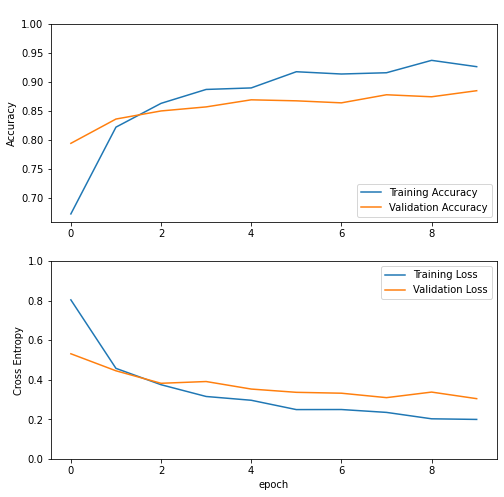

In [57]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')


plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [58]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG',
                '../input/brain-mri-images-for-brain-tumor-detection/no/14 no.jpg']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 83.17 percent confidence.
This image most likely belongs to no_tumor with a 59.64 percent confidence.
This image most likely belongs to meningioma_tumor with a 87.17 percent confidence.
This image most likely belongs to no_tumor with a 99.40 percent confidence.
This image most likely belongs to no_tumor with a 90.98 percent confidence.
This image most likely belongs to pituitary_tumor with a 60.68 percent confidence.


In [59]:
result = model3.evaluate(test)
print(result)

13/13 [==============================] - 1s 57ms/step - loss: 1.3657 - accuracy: 0.7030
[1.365699291229248, 0.703045666217804]


## Fine Tuning the model
<a id='fine_tune'></a>

In [60]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

#Attempting to fine tune more layers
more_layer = 50



#Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


Changing the number of trainable layers doesn't affect the test accuracy too much. 

In [61]:
model3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [62]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 250, 250, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 250, 250, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1280)              0     

In [63]:
len(model3.trainable_variables)

58

In [64]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model3.fit(train,
                         epochs=total_epochs,
                         initial_epoch=history_base.epoch[-1],
                         validation_data=val)

Epoch 10/20
72/72 [==============================] - 13s 133ms/step - loss: 0.2198 - accuracy: 0.9222 - val_loss: 0.3276 - val_accuracy: 0.8902
Epoch 11/20
72/72 [==============================] - 9s 121ms/step - loss: 0.1438 - accuracy: 0.9521 - val_loss: 0.2659 - val_accuracy: 0.8972
Epoch 12/20
72/72 [==============================] - 10s 124ms/step - loss: 0.1065 - accuracy: 0.9686 - val_loss: 0.2793 - val_accuracy: 0.9024
Epoch 13/20
72/72 [==============================] - 10s 122ms/step - loss: 0.0897 - accuracy: 0.9704 - val_loss: 0.2483 - val_accuracy: 0.9059
Epoch 14/20
72/72 [==============================] - 9s 116ms/step - loss: 0.0826 - accuracy: 0.9754 - val_loss: 0.2605 - val_accuracy: 0.9059
Epoch 15/20
72/72 [==============================] - 9s 118ms/step - loss: 0.0677 - accuracy: 0.9842 - val_loss: 0.2358 - val_accuracy: 0.9111
Epoch 16/20
72/72 [==============================] - 9s 121ms/step - loss: 0.0505 - accuracy: 0.9903 - val_loss: 0.2522 - val_accuracy: 0.9

In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

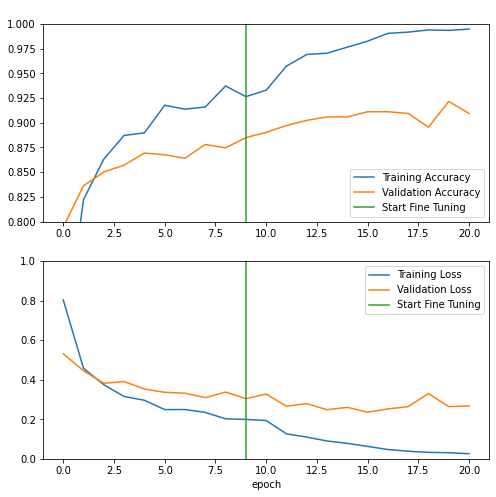

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',fontdict = {'fontsize': '14',
                              'color': 'white'})

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',fontdict = {'fontsize': '14',
                              'color': 'white'})
plt.xlabel('epoch')
plt.show()

In [67]:
loss, accuracy = model3.evaluate(test)
print('Test accuracy :', accuracy)

13/13 [==============================] - 1s 48ms/step - loss: 1.7988 - accuracy: 0.7462
Test accuracy : 0.7461928725242615


In [68]:
list_of_paths = ['../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(20).jpg',
                '../input/brain-tumor-classification-mri/Testing/no_tumor/image(11).jpg',
                '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(120).jpg',
                '../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(16).jpg',
                '../input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG']
test_tumor(list_of_paths,model)

This image most likely belongs to pituitary_tumor with a 83.17 percent confidence.
This image most likely belongs to no_tumor with a 59.64 percent confidence.
This image most likely belongs to meningioma_tumor with a 87.17 percent confidence.
This image most likely belongs to no_tumor with a 99.40 percent confidence.
This image most likely belongs to no_tumor with a 90.98 percent confidence.


prediction_label_comparison is defined [here](#compare)

In [69]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model3.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 3 1 1 0 2 3 2 1 0 1 1 3 1 1 1 1 2 1 3 2 1 2 2 3 2 1 1 1 1 3 1 1 2 1 2 1
 1 0 1 3 2 1 1 2 1 1 0 0 2 3 2 2 2 2 1 1 3 3 2 2 1 3 2 1 2 2 1 2 1 1 1 2 2
 3 2 2 3 3 1 2 2 1 2 2 0 2 2 1 2 3 2 3 2 1 2 1 2 1 1 2 1 1 1 1 3 1 1 1 1 0
 1 2 2 3 1 3 2 1 3 1 1 2 1 2 2 1 1 2 2 1 1 2 2 1 2 3 1 1 2 1 0 1 1 1 3 2 2
 1 2 2 1 3 1 0 0 1 0 3 2 1 1 2 1 3 1 1 2 2 3 1 2 1 2 3 0 1 2 3 2 1 1 2 2 2
 1 1 3 2 3 1 1 2 1 1 2 2 2 2 1 2 0 0 3 1 3 3 1 3 1 1 2 2 1 2 1 2 1 1 1 3 2
 3 0 2 1 1 2 1 1 1 2 0 1 1 1 1 1 2 2 3 2 1 0 2 2 2 2 2 2 1 1 2 1 0 1 2 1 2
 3 2 3 1 1 3 0 2 1 2 1 1 1 1 2 2 3 1 0 3 1 2 3 2 2 2 3 3 0 2 3 3 1 3 2 2 1
 1 1 1 2 2 0 1 1 2 3 2 2 1 3 1 2 1 2 2 1 1 1 3 3 2 1 2 1 3 1 1 1 2 1 2 2 2
 2 2 1 2 2 2 1 1 1 2 2 2 3 1 2 2 3 2 1 3 1 2 2 1 2 0 3 1 1 1 2 1 1 2 1 3 1
 1 2 2 0 2 0 1 2 2 1 0 1 1 3 1 2 2 0 1 1 3 1 1 2]
[1 3 0 1 0 2 3 0 1 0 1 1 3 1 1 1 1 2 0 3 2 2 2 3 3 2 0 1 1 1 3 1 1 3 1 0 0
 1 0 1 3 2 0 1 1 0 0 0 0 2 3 2 2 2 2 1 1 3 3 2 2 3 3 2 1 3 2 1 0 1 0 1 2 2
 3 0 2 3 3 1 2 3 0 2 2 0 2 2 3 2 3 2 3 2 1 2 0 2 0

In [70]:
labels_entire.shape

(394,)

In [71]:
pred_entire.shape

(394,)

In [72]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.27      0.43       100
meningioma_tumor       0.65      0.92      0.76       115
        no_tumor       0.72      0.98      0.83       105
 pituitary_tumor       0.97      0.78      0.87        74

        accuracy                           0.75       394
       macro avg       0.83      0.74      0.72       394
    weighted avg       0.82      0.75      0.71       394



# Using k-fold cross validation

### Reference article for the k-fold cross validation: [Link](https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538)
### Building a .csv file for the images along with their labels: [Reference](https://datascience.stackexchange.com/questions/49094/how-to-transform-a-folder-of-images-into-csv-file)

In [73]:
path_data

PosixPath('../input/brain-tumor-classification-mri/Training')

In [74]:
label_names = os.listdir(path_data)
label_names

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

### Functions csv_builder() and cross_validation() have been defined in the [helper functions](#helper)

In [75]:
final_csv = csv_builder(path_data,label_names)
final_csv

,images,labels
0,../input/brain-tumor-classification-mri/Traini...,no_tumor
1,../input/brain-tumor-classification-mri/Traini...,no_tumor
2,../input/brain-tumor-classification-mri/Traini...,no_tumor
3,../input/brain-tumor-classification-mri/Traini...,no_tumor
4,../input/brain-tumor-classification-mri/Traini...,no_tumor
...,...,...
2865,../input/brain-tumor-classification-mri/Traini...,glioma_tumor
2866,../input/brain-tumor-classification-mri/Traini...,glioma_tumor
2867,../input/brain-tumor-classification-mri/Traini...,glioma_tumor
2868,../input/brain-tumor-classification-mri/Traini...,glioma_tumor


In [76]:
final_csv.to_csv('files_path.csv', header=None)

In [77]:
path_of_csv = './files_path.csv'

In [78]:
test_csv = csv_builder(path_test,label_names)
test_csv

,images,labels
0,../input/brain-tumor-classification-mri/Testin...,no_tumor
1,../input/brain-tumor-classification-mri/Testin...,no_tumor
2,../input/brain-tumor-classification-mri/Testin...,no_tumor
3,../input/brain-tumor-classification-mri/Testin...,no_tumor
4,../input/brain-tumor-classification-mri/Testin...,no_tumor
...,...,...
389,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
390,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
391,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
392,../input/brain-tumor-classification-mri/Testin...,glioma_tumor


In [79]:
test_csv = test_csv.sample(frac=1)
test_csv

,images,labels
201,../input/brain-tumor-classification-mri/Testin...,meningioma_tumor
11,../input/brain-tumor-classification-mri/Testin...,no_tumor
377,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
341,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
289,../input/brain-tumor-classification-mri/Testin...,meningioma_tumor
...,...,...
167,../input/brain-tumor-classification-mri/Testin...,pituitary_tumor
232,../input/brain-tumor-classification-mri/Testin...,meningioma_tumor
348,../input/brain-tumor-classification-mri/Testin...,glioma_tumor
189,../input/brain-tumor-classification-mri/Testin...,meningioma_tumor


### Defining number of folds

In [80]:
k = 5

### Now this csv file can be used to create a kfold split in the training data

## Cross validation on the [first model](#first_model)

In [81]:
num_classes = 4

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [82]:
loss,acc,model = cross_validation(k,final_csv,test_csv,img_width,img_height,model = model)

Performing cross validation...
Found 394 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 154ms/step - loss: 1.7566 - accuracy: 0.5355
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 151ms/step - loss: 2.0188 - accuracy: 0.6472
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 3s 209ms/step - loss: 2.2674 - accuracy: 0.6751
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 178ms/step - loss: 2.5096 - accuracy: 0.7183
Found 2296 validated image filenames belonging to 4 classes.
Found 57

In [83]:
print(loss,acc)

2.269030809402466 0.6644670009613037


In [84]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 2 2 2 1 1 2 1 2 2 2 1 2 1 2 2 2 1 1 2 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 1 2
 1 2 2 2 2 1 2 2 1 2 1 2 1 1 1 2 1 1 1 2 2 2 1 2 1 2 2 2 2 1 2 2 1 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 1 2 2 1 2 1 2 2 1 2 2 2 1 2 2 2 1 1 2 2 2
 2 1 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 1 1 1 3 2 2 2 1 2 1 2 2 2 2 2 1 1 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 1 1 2 2
 1 2 2 1 1 2 2 2 1 2 2 1 2 2 2 2 1 2 2 1 1 2 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2
 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 1 1 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 1 2 1 2 1 2 1 1 2 2 2 1 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 1 2 2 1 2 3 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 1 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1
 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2]
[2 1 3 1 3 3 3 2 3 1 2 1 1 1 2 3 2 0 3 2 1 2 1 3 1 0 2 0 2 2 1 1 2 1 0 2 1
 0 2 1 3 2 1 0 3 0 3 3 1 0 1 0 0 1 1 3 2 0 3 1 0 3 1 1 2 2 0 3 0 2 1 2 0 2
 1 1 2 0 3 3 1 2 2 3 2 0 0 1 2 2 1 2 2 3 2 1 0 1 0

In [85]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.32      0.30      0.31       115
        no_tumor       0.32      0.87      0.47       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.32       394
       macro avg       0.16      0.29      0.19       394
    weighted avg       0.18      0.32      0.21       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation on [Second Model](#second_model)

In [86]:
num_classes = 4

model2 = tf.keras.Sequential([
  #data_augmentation,
  normalization_layer,
  #tf.keras.layers.Conv2D(32,3,activation='relu'),
  layers.Conv2D(32,(3,3),activation='relu'),
  layers.MaxPooling2D(),#pool_size=(2,2)),
  layers.Conv2D(32,(3,3),activation='relu'),
  layers.MaxPooling2D(),#pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
loss,acc,model2 = cross_validation(k,final_csv,test_csv,img_width,img_height,model = model2)
print(loss,acc)

Performing cross validation...
Found 394 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 186ms/step - loss: 2.4261 - accuracy: 0.5685
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 149ms/step - loss: 3.7070 - accuracy: 0.6980
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 154ms/step - loss: 4.9311 - accuracy: 0.7107
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 149ms/step - loss: 5.6469 - accuracy: 0.7310
Found 2296 validated image filenames belonging to 4 classes.
Found 57

In [88]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model2.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[1 2 1 2 1 2 1 2 2 2 2 1 2 1 2 2 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 2 1 1 2 2 2
 2 2 1 2 2 2 1 2 1 1 2 2 2 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2 2 2 1 1 2 2 2 2
 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2
 3 1 2 2 1 2 2 2 2 2 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 1 1 1 1 2 1 2 2 2 1 2 2
 2 2 2 1 2 1 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 1 1 2 1 2 2 1 1
 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 2 1 2
 2 2 1 1 1 2 1 1 2 1 2 1 2 2 2 2 2 2 2 1 2 2 2 2 1 2 1 2 2 1 2 1 2 1 1 1 2
 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 1 1 2 3 2 2]
[1 1 0 2 2 2 0 0 2 2 1 1 1 2 3 2 3 1 2 3 0 3 0 3 2 1 2 0 3 2 0 1 0 0 0 0 3
 2 1 0 0 0 1 2 0 1 0 3 3 2 3 3 2 1 2 0 1 0 2 3 2 2 2 1 1 1 0 2 3 0 1 2 1 2
 3 1 0 2 1 2 1 0 1 1 1 1 2 0 0 3 0 1 0 1 1 1 2 2 0

In [89]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.32      0.30      0.31       115
        no_tumor       0.32      0.87      0.47       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.32       394
       macro avg       0.16      0.29      0.19       394
    weighted avg       0.18      0.32      0.21       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross Validation on Third Model

In [90]:
model3 = tf.keras.Sequential([normalization_layer,
                                  conv_layer_32,
                                  max_pool,
                                  #layers.MaxPooling2D(pool_size=(2,2)),
                                  conv_layer_32,
                                  max_pool,
                                  #layers.MaxPooling2D(pool_size=(2,2)),
                                  layers.Flatten(),
                                  layers.Dense(128, activation='relu'),
                                  #layers.Dropout(0.25),
                                  layers.Dense(num_classes,activation='softmax')
                                 ])
model3.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

In [91]:
loss,acc,model3 = cross_validation(k,final_csv,test_csv,img_width,img_height,model3)
print(loss,acc)

Performing cross validation...
Found 394 validated image filenames belonging to 4 classes.
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 149ms/step - loss: 1.8607 - accuracy: 0.6193
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 153ms/step - loss: 1.8054 - accuracy: 0.6599
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 2s 172ms/step - loss: 2.0242 - accuracy: 0.7360
Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
13/13 [==============================] - 3s 186ms/step - loss: 2.7812 - accuracy: 0.7284
Found 2296 validated image filenames belonging to 4 classes.
Found 57

In [92]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test.as_numpy_iterator():
    prediction = model3.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-4):
        pred = np.argmax(predictions[n:n+4]) #Returns the index of the largest element in the selected subarray
        n+=4
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2
 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 1 1 1 2 2 1 2 2 2 1 2 2 2 2 2 2 1 2 2 1 2 2 1 2 2 2 2 2 1 1 1 1
 1 2 2 2 1 2 1 1 1 2 1 1 2 2 1 1 2 1 2 2 2 2 2 1 1 2 1 2 2 1 1 1 2 2 1 2 2
 2 2 2 2 1 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 1
 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 1 2 2 1 1 2 2 1 1 1 1 2 2 2 2 1 2 2 2 2 2
 2 2 2 1 2 1 3 2 1 2 2 1 2 1 2 1 2 2 1 1 1 2 2 2 2 2 1 1 2 1 2 2 2 1 2 2 2
 1 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2 1 1 2 1 2 2 1 2 2
 2 1 2 2 2 2 2 2 1 2 2 2 3 2 2 2 1 2 1 2 1 2 2 2]
[1 3 3 2 1 1 2 2 1 3 1 0 1 1 2 0 2 1 1 3 3 2 0 1 3 0 0 2 1 3 0 2 3 1 2 1 1
 2 0 0 0 0 1 2 0 0 2 1 3 0 1 3 0 1 0 0 3 2 3 2 1 1 1 2 1 1 0 2 0 2 1 2 2 1
 1 2 2 1 2 1 1 1 1 0 1 2 1 3 3 2 0 2 1 0 1 0 0 2 3

In [93]:
print(classification_report(labels_entire, pred_entire, target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.00      0.00      0.00       100
meningioma_tumor       0.34      0.31      0.32       115
        no_tumor       0.31      0.85      0.46       105
 pituitary_tumor       0.00      0.00      0.00        74

        accuracy                           0.32       394
       macro avg       0.16      0.29      0.20       394
    weighted avg       0.18      0.32      0.22       394



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
